# Importing Libraries

In [1]:
import os
import cv2
import sys
import tqdm
import imageio
import numpy as np
import matplotlib.pyplot as plt

# Tensorflow
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers

# Some constants
lr = 1e-4
batch_size = 64
epochs = 100
img_shape = (112, 112, 3)
latent_dim = 100
num_img_to_gen = 16
g_weights_path = "weights/g.weights.hdf5"
d_weights_path = "weights/d.weights.hdf5"

# Building the models

## 1. Generator

In [2]:
def make_generator():
    inputs = Input(shape=(latent_dim,))
    
    x = Dense(7*7*256, use_bias=False)(inputs)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Reshape(target_shape=(7,7,256))(x)
    
    # Size = 128 x 14 x 14 
    x = Conv2DTranspose(128, kernel_size=(4,4), strides=(2,2), padding='same',
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    # Size = 64 x 28 x 28
    x = Conv2DTranspose(64, kernel_size=(4,4), strides=(2,2), padding='same',
                       use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    # Size = 32 x 56 x 56
    x = Conv2DTranspose(32, kernel_size=(4,4), strides=(2,2), padding='same',
                       use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    # Size = 16 x 112 x 112
    x = Conv2DTranspose(16, kernel_size=(4,4), strides=(2,2), padding='same',
                       use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    # Use tanh so that it is [-1, 1]
    x = Conv2D(img_shape[-1], kernel_size=(4,4), padding='same', use_bias=False, activation='tanh')(x)
    
    model = Model(inputs=inputs, outputs=x, name='Generator')
    return model

G = make_generator()
G.summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       524288    
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 128)       0 

## 2. Discriminator

In [144]:
def make_discriminator():
    inputs = Input(shape=img_shape)
    
    x = Conv2D(16, kernel_size=(4,4), strides=(2,2), padding='same')(inputs)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)
    
    x = Conv2D(32, kernel_size=(4,4), strides=(2,2), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)
    
    x = Conv2D(64, kernel_size=(4,4), strides=(2,2), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    
    x = Conv2D(128, kernel_size=(4,4), strides=(2,2), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)
    
    x = Flatten()(x)
    x = Dense(1)(x)
    
    model = Model(inputs=inputs, outputs=x, name='Discriminator')
    return model

D = make_discriminator()
D.summary()

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_74 (InputLayer)        [(None, 112, 112, 3)]     0         
_________________________________________________________________
conv2d_165 (Conv2D)          (None, 56, 56, 16)        784       
_________________________________________________________________
leaky_re_lu_313 (LeakyReLU)  (None, 56, 56, 16)        0         
_________________________________________________________________
dropout_128 (Dropout)        (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_166 (Conv2D)          (None, 28, 28, 32)        8224      
_________________________________________________________________
leaky_re_lu_314 (LeakyReLU)  (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_129 (Dropout)        (None, 28, 28, 32)      

# Definition of loss functions

## 1. Generator Loss

In [145]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
mse = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)
'''
    Evaluates how well the Generator can deceive the Discriminator
    Calculated by taking the binary cross entropy of D(G(z)) w.r.t ones
'''
def generator_loss(D_fake):
    loss = bce(tf.ones_like(D_fake, dtype=tf.float32), D_fake)
    return loss

## 2. Discriminator Loss

In [146]:
'''
    Evaluates how well the discriminator is able to separate true and fake instances
    Calculated by taking the sume of bce(D(G(z)), 0) and bce(D(x), 1)
'''
def discriminator_loss(D_true, D_fake):
    fake_loss = bce(tf.zeros_like(D_fake, dtype=tf.float32), D_fake)
    true_loss = bce(tf.ones_like(D_true, dtype=tf.float32)*0.9, D_true)
    loss = fake_loss + true_loss
    
    return loss

# Preparing the dataset

Found 202599 images belonging to 10177 classes.


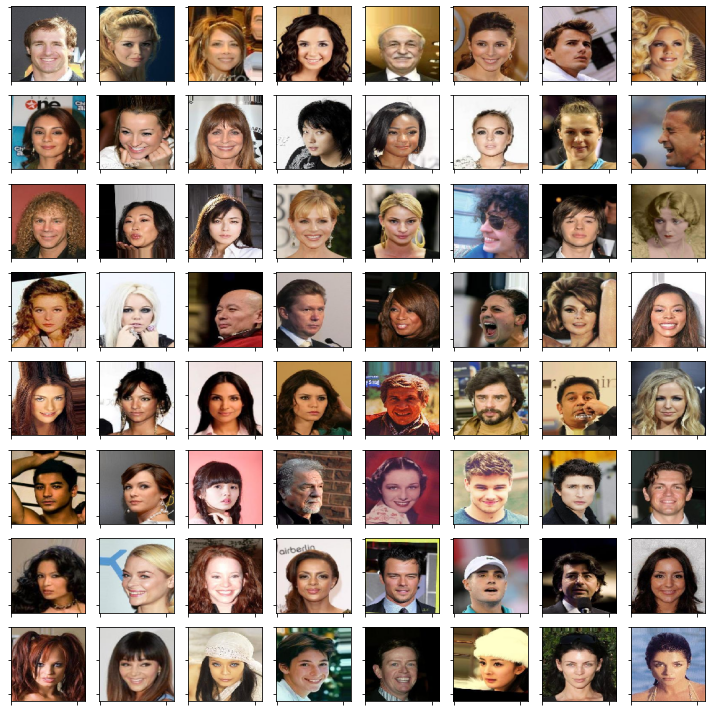

In [147]:
def preprocess(img):
    # normalize
    img = (img - 127.5) / 127.5
    img = img.astype(np.float32)
    
    return img
    
generator = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess)
dataset = generator.flow_from_directory("/home/minhhieu/Desktop/Hieu/datasets/img_align_celeba",
                                       target_size=(img_shape[0], img_shape[1]),
                                       batch_size=batch_size)
dataset_size = len(dataset)

# Display sample images
batchX, batchY = next(dataset)
grid_size = int(np.sqrt(batch_size))

fig, ax = plt.subplots(grid_size, grid_size, figsize=(10, 10))
for i in range(batch_size):
    row = i // grid_size
    col = i %  grid_size
    
    img = ((batchX[i] * 127.5) + 127.5).astype(np.uint8)
    
    ax[row][col].set_xticklabels([])
    ax[row][col].set_yticklabels([])
    ax[row][col].imshow(img)
    
plt.tight_layout()
plt.show()

# Start the training process

In [148]:
# Define the optimizers
g_opt = optimizers.Adam(learning_rate=lr, beta_1=0.5, decay=0.00005)
d_opt = optimizers.Adam(learning_rate=lr, beta_1=0.5, decay=0.00005)

D = make_discriminator()
G = make_generator()

# Define training step per batch
def train_step(images):
    noise = tf.random.normal([batch_size, latent_dim])
    
    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
        fake_img = G(noise, training=True)
        
        real_output = D(images, training=True)
        fake_output = D(fake_img, training=True)
        
        g_loss = generator_loss(fake_output)
        d_loss = discriminator_loss(real_output, fake_output)
        
        g_loss = K.mean(g_loss)
        d_loss = K.mean(d_loss)
        
    d_gradient = d_tape.gradient(d_loss, D.trainable_variables)
    g_gradient = g_tape.gradient(g_loss, G.trainable_variables)
    
    d_opt.apply_gradients(zip(d_gradient, D.trainable_variables))
    g_opt.apply_gradients(zip(g_gradient, G.trainable_variables))
    
    return g_loss.numpy(), d_loss.numpy()

In [149]:
# Define the training loop
fixed_latent = tf.random.normal([num_img_to_gen, latent_dim])
grid_size = int(np.sqrt(num_img_to_gen))

def generate_img(latent):
    images = G(latent, training=False).numpy()
    images = ((images * 127.5) + 127.5).astype(np.uint8)

    result = None
    for i in range(grid_size):
        row = None
        for j in range(grid_size):
            index = grid_size * i + j
            if(j == 0):
                row = images[index]
            else:
                row = cv2.hconcat([row, images[index]])
        if(result is None):
            result = row
        else:
            result = cv2.vconcat([result, row])
    
    return result

def generate_gif(images):
    with imageio.get_writer("images/output.gif", mode="I") as writer:
        for i, image in enumerate(images):
            # put frame number
            image = cv2.putText(image, str(i), (10,10), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,0,0))
            image = imageio.core.util.Array(image)
            writer.append_data(image)
        
    
def train(dataset):
    images = []
    # Check if checkpoint files exists
    if(os.path.exists(g_weights_path) and os.path.exists(d_weights_path)):
        print('[INFO] Loading checkpoints ...')
        G.load_weights(g_weights_path)
        D.load_weights(d_weights_path)
    
    for epoch in range(epochs):
        with tqdm.tqdm(total=dataset_size, file=sys.stdout) as pbar:
            g_losses = []
            d_losses = []
            for i in range(dataset_size):
                batchX, batchY = next(dataset)
                g_loss, d_loss = train_step(batchX)
                g_losses.append(g_loss)
                d_losses.append(d_loss)
                
                if((i + 1) % (dataset_size//10) == 0):
                    print(f"[INFO] Generating Gif ... L_g = {g_loss}, L_d = {d_loss}")
                    gen_image = generate_img(fixed_latent)
                    images.append(gen_image)
                    generate_gif(images)
                
                pbar.update(1)
            mean_g_loss = np.array(g_losses).mean()
            mean_d_loss = np.array(d_losses).mean()
            
            print(f'\n\n[INFO] Epoch #[{epoch}/{epochs}] Generator Loss = {mean_g_loss} | Discriminator Loss = {mean_d_loss}')
            
train(dataset)

[INFO] Loading checkpoints ...
100%|██████████| 3166/3166 [03:23<00:00,  9.33it/s]

[INFO] Epoch #[0/100] Generator Loss = 1.1409231424331665 | Discriminator Loss = 1.1708588600158691
100%|██████████| 3166/3166 [03:31<00:00,  6.52it/s]

[INFO] Epoch #[1/100] Generator Loss = 1.062821626663208 | Discriminator Loss = 1.2046875953674316
100%|██████████| 3166/3166 [03:40<00:00,  4.95it/s]

[INFO] Epoch #[2/100] Generator Loss = 1.0374668836593628 | Discriminator Loss = 1.2170836925506592
100%|██████████| 3166/3166 [03:51<00:00,  4.12it/s]

[INFO] Epoch #[3/100] Generator Loss = 1.0263874530792236 | Discriminator Loss = 1.2266359329223633
 26%|██▌       | 815/3166 [00:58<02:48, 13.94it/s]


KeyboardInterrupt: 

In [ ]:
# Checkpoint the models
print("[INFO] Checkpointing Generator ... ")
G.save_weights(g_weights_path)

print("[INFO] Checkpointing Discriminator ... ")
D.save_weights(d_weights_path)